In [23]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.metrics import structural_similarity

def write_csv(name, m):
    sourceFile = open(name, 'w')
    strm = str(m)
    print(strm[1:-1], file = sourceFile)
    sourceFile.close()
    
def show(ims):
    plt.figure(figsize=(5*len(ims),5))
    
    for i in range(len(ims)):
        plt.subplot(1,len(ims),i+1)
        plt.imshow(ims[i])
        
def ssim(im1, im2, data_range=255):
    return structural_similarity(im1, im2, gaussian_weights=True, sigma=1.5, use_sample_covariance=False, data_range=data_range)
  

In [24]:
gt = np.load('data/gt.npy').astype(int)
pred = np.load('data/pred.npy').astype(int)
print(gt.shape)

(100, 64, 64)


0.39508186247017696


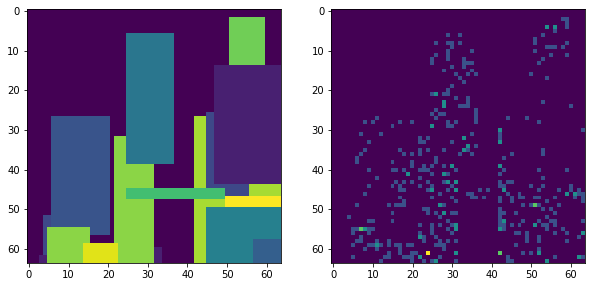

In [25]:
n = 18
print(ssim(gt[n,:,:], pred[n,:,:]))
show([gt[n,:,:], pred[n,:,:]])

In [26]:
b = gt.shape[0]
m = []
for i in range(b):
    m.append( ssim( gt[i,:,:], pred[i,:,:] ) )
    
print(m)

[0.659702066136305, 0.23089819448998147, 0.3429739744089346, 0.7784842470920817, 0.7403292040379931, 0.38939124968541816, 0.44373917558371867, 0.7163733564654953, 0.634717636425133, 0.266045844351291, 0.2917695750656713, 0.27976797152076244, 0.34236844304661657, 0.5996328329823875, 0.2120394788668411, 0.3705793046254481, 0.5313046831594909, 0.540596394691194, 0.39508186247017696, 0.5173128866092221, 0.3803837548341339, 0.6209244099968357, 0.5405677784702972, 0.3049941586010834, 0.29742337026490173, 0.1310596012731726, 0.543655471913738, 0.5427248143887671, 0.3306918855848134, 0.7121139379557905, 0.7222660729277381, 0.2839121257020358, 0.3193077745278084, 0.1925174077242355, 0.45945521638733783, 0.5904992213057477, 0.47266358883386905, 0.5873094952167104, 0.7711310923733481, 0.12252095212801364, 0.29677216091559583, 0.334906543075205, 0.29719456540210837, 0.54267377092024, 0.7045367235751367, 0.2846505399322784, 0.39604038428968247, 0.30217844237612673, 0.36689551436946616, 0.4661823996

In [27]:
write_csv('data/ssim.txt', m)

In [28]:
# Toy example
dims = (32, 32)

r = np.zeros(dims)
p = np.zeros(dims)

for i in range(dims[0]):
    for j in range(dims[1]):
        r[i,j] = i
        p[i,j] = i+j


ssim(r,p)

0.7433402662472663

In [30]:
# Toy example
dims = (32, 32)

r = np.zeros(dims)
p = np.zeros(dims)

for i in range(dims[0]):
    for j in range(dims[1]):
        r[i,j] = i
        p[i,j] = i+j


ssim(r,p)

0.7433402662472663